# **Construisez un modèle de scoring**



![logo.JPG](data/img/logo.JPG)

La société financière **"Prêt à dépenser"** propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

Pour accorder un crédit à la consommation, l’entreprise souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé.

Le but est donc de développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

---

## Sommaire

<ol>
    <li><a href="#">Environnement de développement</a></li>
        <ol>
            <li><a href="#installation">Installation de l'environnement</a></li>
            <li><a href="#librairies">Import des librairies</a></li>
        </ol>
    <li><a href="#"></a></li>
</ol>



<a id="environnement"></a>
# Environnement de développement

<a id="installation"></a>
### Installation de l'environnement

Un environnement virtuel a été créé pour assurer l’isolement du projet et la gestion des dépendances.
Les informations de cet environnement (son nom et ses dépendances) sont précisées dans le fichier **environment.yml**

L'installation de l'environnement virtuel est possible à partir de ce fichier, dans un invite de commande lancer la commande :

<code>conda env create -f environment.yml</code>

<a id="librairies"></a>
### Import des librairies

In [161]:
%reload_ext autoreload
%autoreload 2

import gc

# numpy et pandas pour la manipulation du data
import numpy as np
import pandas as pd

# sklearn preprocessing pour traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib et seaborn pour tracer les graphes
import matplotlib.pyplot as plt
import seaborn as sns

#autres librairies
import missingno as msno

# Import des modules contenant les fonctions utilitaires
import src.my_module.data_helpers as dth

In [162]:
# Réglage des graphiques
plt.style.use('seaborn-whitegrid')

plt.rc('font', size=12)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

dims_fig = (25,35)

# Chargement des données

In [163]:
#Affichage de la liste des différents fichiers
print("Liste des fichiers :")
for file in os.listdir("data/"):
    if file.endswith(".csv"):
        print("- " + file)

Liste des fichiers :
- application_test.csv
- application_train.csv
- bureau.csv
- bureau_balance.csv
- credit_card_balance.csv
- HomeCredit_columns_description.csv
- installments_payments.csv
- POS_CASH_balance.csv
- previous_application.csv
- sample_submission.csv


Ces fichiers sont fournis par <a href="https://www.homecredit.net//">Home Credits</a>, un service dédié à l'octroi de crédits à ceux qui n'ont pas d'historique de crédit.

Le diagramme suivant montre comment toutes les données sont liées :

![home_credit.png](data/img/home_credit.png)

On retrouve la définition de chaque colonne dans le fichier HomeCredit_columns_description.csv

On va charger dans un premier temps les données des fichier **application_train.csv** et **application_test.csv**, que l'on va fusionner pour ensuite effectuer un nettoyage et la création de nouvelles features. On reséparera par la suite le dataset correctement pour l'entraînement de nos différents modèles, car :

- Le fichier **application_train.csv** contient la colonne TARGET, qui est la valeur que l'on essaye de prédire, alors que le fichier **application_test.csv** quand à lui ne contient pas cette colonne TARGET.

In [164]:
# Jeu d'entraînement
data = pd.read_csv('data/application_train.csv')
dth.displayDataShape("Le jeu d'entraînement contient", data)

Le jeu d'entraînement contient : 307511 lignes et 122 colonnes



In [165]:
data.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
# Jeu de test
test_data = pd.read_csv('data/application_test.csv')
dth.displayDataShape("Le jeu de test contient", test_data)

Le jeu de test contient : 48744 lignes et 121 colonnes



In [167]:
test_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Le jeu de test est plus petit et ne contient pas la variable TARGET

# Analyse exploratoire
Avant de fusionner les 2 fichiers pour effectuer différents traitements, nous analyserons les différentes variables du jeu de données d'entraînement.

### La colonne TARGET
La variable **TARGET** est celle que notre modèle doit prédire

- TARGET=1 correspond à un prêt non remboursé
- TARGET=0 correspond à un prêt remboursé

In [168]:
data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Nous avons affaire ici à un problème de classification binaire, avec un **jeu d'entraînement déséquilibré**.
Il y a beaucoup plus de prêts remboursés que de prêts non remboursés.

Il faudra rééquilibrer ces classes avant d'entraîner un modèle supervisé.

### Valeurs manquantes
On va maintenant examiner le nombre de valeurs manquantes pour chaque colonne

In [169]:
print("Affichage du nombre de valeurs manquantes en % pour chaque colonne")
dth.displayNanPercent(data)

Affichage du nombre de valeurs manquantes en % pour chaque colonne
Le jeu de données contient 122 colonnes.
67 colonnes ont des valeurs manquantes.


,Valeurs manquantes,% de valeurs manquantes
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


In [170]:
print("Affichage graphique du remplissage des colonnes")
#msno.bar(data)

Affichage graphique du remplissage des colonnes


La plupart des colonnes sont bien remplies, et les moins remplies ont au moins 30% de valeurs non nulles, on va donc garder toutes les colonnes pour le moment.

Cela ne devrait pas poser de problème pour la suite, mais il faudra quand même imputer ces valeurs manquantes.

### Types des colonnes

In [171]:
data.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [172]:
data_object_infos = data.select_dtypes("object").describe().T
data_object_infos["unique"] = data.select_dtypes("object").apply( pd.Series.unique, axis=0)
data_object_infos["nunique"] = data.select_dtypes("object").apply( pd.Series.nunique, axis=0)
data_object_infos

,count,unique,top,freq,nunique
NAME_CONTRACT_TYPE,307511,"[Cash loans, Revolving loans]",Cash loans,278232,2
CODE_GENDER,307511,"[M, F, XNA]",F,202448,3
FLAG_OWN_CAR,307511,"[N, Y]",N,202924,2
FLAG_OWN_REALTY,307511,"[Y, N]",Y,213312,2
NAME_TYPE_SUITE,306219,"[Unaccompanied, Family, Spouse, partner, Child...",Unaccompanied,248526,7
NAME_INCOME_TYPE,307511,"[Working, State servant, Commercial associate,...",Working,158774,8
NAME_EDUCATION_TYPE,307511,"[Secondary / secondary special, Higher educati...",Secondary / secondary special,218391,5
NAME_FAMILY_STATUS,307511,"[Single / not married, Married, Civil marriage...",Married,196432,6
NAME_HOUSING_TYPE,307511,"[House / apartment, Rented apartment, With par...",House / apartment,272868,6
OCCUPATION_TYPE,211120,"[Laborers, Core staff, Accountants, Managers, ...",Laborers,55186,18


In [173]:
data_int_infos = pd.DataFrame(data.select_dtypes("int64").apply(pd.Series.nunique,axis=0),columns=["Nombre de valeur unique"])
data_int_infos["valeur unique"] = data.select_dtypes("int64").apply(pd.Series.unique,axis=0)
data_int_infos.sort_values(by="Nombre de valeur unique")

,Nombre de valeur unique,valeur unique
LIVE_CITY_NOT_WORK_CITY,2,"[0, 1]"
FLAG_DOCUMENT_3,2,"[1, 0]"
FLAG_DOCUMENT_4,2,"[0, 1]"
FLAG_DOCUMENT_5,2,"[0, 1]"
FLAG_DOCUMENT_6,2,"[0, 1]"
FLAG_DOCUMENT_7,2,"[0, 1]"
FLAG_DOCUMENT_8,2,"[0, 1]"
FLAG_DOCUMENT_9,2,"[0, 1]"
FLAG_DOCUMENT_10,2,"[0, 1]"
FLAG_DOCUMENT_11,2,"[0, 1]"


In [174]:
data_float_infos = pd.DataFrame(data.select_dtypes("float64").apply(pd.Series.nunique,axis=0),columns=["Nombre de valeur unique"])
data_float_infos["valeur unique"] = data.select_dtypes("float64").apply(pd.Series.unique,axis=0)
data_float_infos.sort_values(by="Nombre de valeur unique")

,Nombre de valeur unique,valeur unique
AMT_REQ_CREDIT_BUREAU_HOUR,5,"[0.0, nan, 1.0, 2.0, 3.0, 4.0]"
AMT_REQ_CREDIT_BUREAU_WEEK,9,"[0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 8.0, ..."
AMT_REQ_CREDIT_BUREAU_DAY,9,"[0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 9.0, ..."
DEF_60_CNT_SOCIAL_CIRCLE,9,"[2.0, 0.0, 1.0, nan, 3.0, 5.0, 4.0, 7.0, 24.0,..."
DEF_30_CNT_SOCIAL_CIRCLE,10,"[2.0, 0.0, 1.0, nan, 3.0, 4.0, 5.0, 6.0, 7.0, ..."
...,...,...
AMT_CREDIT,5603,"[406597.5, 1293502.5, 135000.0, 312682.5, 5130..."
AMT_ANNUITY,13672,"[24700.5, 35698.5, 6750.0, 29686.5, 21865.5, 2..."
DAYS_REGISTRATION,15688,"[-3648.0, -1186.0, -4260.0, -9833.0, -4311.0, ..."
EXT_SOURCE_1,114584,"[0.0830369673913225, 0.3112673113812225, nan, ..."


### Analyse des variables

In [175]:
#dth.drawPieplot(data, data.select_dtypes("object").columns, (25,100))

In [176]:
#dth.drawHistAndBoxPlot(data, data.select_dtypes("int64").columns, (25,250))

In [177]:
#dth.drawHistAndBoxPlot(data, data.select_dtypes("float64").columns, (25,250))

In [178]:
positive_target = data[data["TARGET"]==1]
negative_target = data[data['TARGET']==0]
#dth.analyse_num_with_target_bin(positive_target, negative_target, 'TARGET')

# Merge des fichiers, et création de nouvelles variables

In [179]:
data = data.append(test_data).reset_index()

In [180]:
dth.displayDataShape("data", data)

data : 356255 lignes et 123 colonnes



### Nettoyage
On va ici supprimer les valeurs aberrantes

In [181]:
data['CODE_GENDER'].value_counts()

F      235126
M      121125
XNA         4
Name: CODE_GENDER, dtype: int64

On supprime les 4 lignes qui ne contiennent pas de valeurs adéquates pour la variable 'CODE_GENDER'

In [182]:
data = data[data['CODE_GENDER'] != "XNA"]

In [183]:
data['DAYS_EMPLOYED'].describe()

count    356251.000000
mean      64317.999498
std      141706.142236
min      -17912.000000
25%       -2781.000000
50%       -1224.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

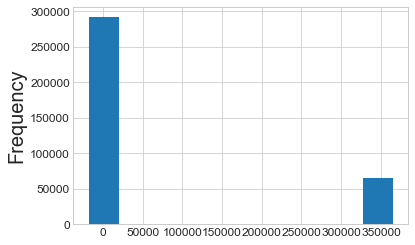

In [184]:
data['DAYS_EMPLOYED'].plot.hist();

Il ne doit y avoir que des valeurs négatives pour la variable 'DAYS_EMPLOYED', on remplace donc les valeurs aberrantes par la valeur NaN

In [185]:
data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

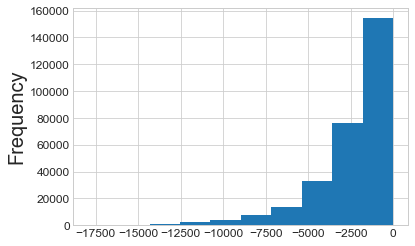

In [186]:
data['DAYS_EMPLOYED'].plot.hist();

### Encodage des variables catégorielles
blablablabla Explications ....... TODO

In [187]:
data_object_infos = data.select_dtypes("object").describe().T
data_object_infos["unique"] = data.select_dtypes("object").apply( pd.Series.unique, axis=0)
data_object_infos["nunique"] = data.select_dtypes("object").apply( pd.Series.nunique, axis=0)
data_object_infos

,count,unique,top,freq,nunique
NAME_CONTRACT_TYPE,356251,"[Cash loans, Revolving loans]",Cash loans,326537,2
CODE_GENDER,356251,"[M, F]",F,235126,2
FLAG_OWN_CAR,356251,"[N, Y]",N,235233,2
FLAG_OWN_REALTY,356251,"[Y, N]",Y,246966,2
NAME_TYPE_SUITE,354048,"[Unaccompanied, Family, Spouse, partner, Child...",Unaccompanied,288250,7
NAME_INCOME_TYPE,356251,"[Working, State servant, Commercial associate,...",Working,183304,8
NAME_EDUCATION_TYPE,356251,"[Secondary / secondary special, Higher educati...",Secondary / secondary special,252377,5
NAME_FAMILY_STATUS,356251,"[Single / not married, Married, Civil marriage...",Married,228712,6
NAME_HOUSING_TYPE,356251,"[House / apartment, Rented apartment, With par...",House / apartment,316510,6
OCCUPATION_TYPE,244257,"[Laborers, Core staff, Accountants, Managers, ...",Laborers,63841,18


In [188]:
# Object label encoder
le = LabelEncoder()
le_count = 0
col_encoded = []

for col in data:
    if data[col].dtype == 'object':
        if len(list(data[col].unique())) <= 2:
            le.fit(data[col])
            data[col] = le.transform(data[col])
            le_count += 1
            col_encoded.append(col)



In [189]:
data, cols_one_hot_encoded = dth.one_hot_encoder(data, False)
print(f'{len(cols_one_hot_encoded)} colonnes on été "one hot encoded" :')
for col in cols_one_hot_encoded:
    print(f"- {col}")

131 colonnes on été "one hot encoded" :
- NAME_TYPE_SUITE_Children
- NAME_TYPE_SUITE_Family
- NAME_TYPE_SUITE_Group of people
- NAME_TYPE_SUITE_Other_A
- NAME_TYPE_SUITE_Other_B
- NAME_TYPE_SUITE_Spouse, partner
- NAME_TYPE_SUITE_Unaccompanied
- NAME_INCOME_TYPE_Businessman
- NAME_INCOME_TYPE_Commercial associate
- NAME_INCOME_TYPE_Maternity leave
- NAME_INCOME_TYPE_Pensioner
- NAME_INCOME_TYPE_State servant
- NAME_INCOME_TYPE_Student
- NAME_INCOME_TYPE_Unemployed
- NAME_INCOME_TYPE_Working
- NAME_EDUCATION_TYPE_Academic degree
- NAME_EDUCATION_TYPE_Higher education
- NAME_EDUCATION_TYPE_Incomplete higher
- NAME_EDUCATION_TYPE_Lower secondary
- NAME_EDUCATION_TYPE_Secondary / secondary special
- NAME_FAMILY_STATUS_Civil marriage
- NAME_FAMILY_STATUS_Married
- NAME_FAMILY_STATUS_Separated
- NAME_FAMILY_STATUS_Single / not married
- NAME_FAMILY_STATUS_Unknown
- NAME_FAMILY_STATUS_Widow
- NAME_HOUSING_TYPE_Co-op apartment
- NAME_HOUSING_TYPE_House / apartment
- NAME_HOUSING_TYPE_Municipal

In [190]:
dth.displayDataShape("Data après l'encodage", data)

Data après l'encodage : 356251 lignes et 242 colonnes



### Création de nouvelles features

In [191]:
data['DAYS_EMPLOYED_PERC'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['INCOME_CREDIT_PERC'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
data['ANNUITY_INCOME_PERC'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['PAYMENT_RATE'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
del test_data
gc.collect()

7491

### Fusion des autres fichiers, encodage et créations d'autres variables
On reprend le même principe pour les autres fichiers et on les ajoute à notre fichier de data. La jonction se fait grâce au **SK_ID_CURR**

Fichiers **Bureau et bureau_balance**

In [192]:
bureau = pd.read_csv('data/bureau.csv')
bb = pd.read_csv('data/bureau_balance.csv')

bureau = dth.bureau_and_balance(bureau, bb)

dth.displayDataShape("Bureau data", bureau)
data = data.join(bureau, how='left', on='SK_ID_CURR')
del bureau
gc.collect()

Bureau : 305811 lignes et 116 colonnes



0

Fichier **previous_application**

In [194]:
prev = pd.read_csv('data/previous_application.csv')

prev = dth.previous_applications(prev)

dth.displayDataShape("Previous application data", prev)
data = data.join(prev, how='left', on='SK_ID_CURR')
del prev
gc.collect()

Previous application data : 338857 lignes et 249 colonnes



0

Fichier **POS-CASH balance**

In [195]:
pos = pd.read_csv('data/POS_CASH_balance.csv')

pos = dth.pos_cash(pos)

dth.displayDataShape("POS-CASH balance data", pos)
data = data.join(pos, how='left', on='SK_ID_CURR')
del pos
gc.collect()

POS-CASH balance data : 337252 lignes et 18 colonnes



0

Fichier **installments payments**

In [196]:
ins = pd.read_csv('data/installments_payments.csv')

ins = dth.installments_payments(ins)

dth.displayDataShape("Installments payments data", ins)
data = data.join(ins, how='left', on='SK_ID_CURR')
del ins
gc.collect()

Installments payments data : 339587 lignes et 26 colonnes



0

Fichier **credit card balance**

In [197]:
cc = pd.read_csv('data/credit_card_balance.csv')

cc = dth.credit_card_balance(cc)

dth.displayDataShape("Credit card balance data", cc)
data = data.join(cc, how='left', on='SK_ID_CURR')
del cc
gc.collect()

Credit card balance data : 103558 lignes et 141 colonnes



0